# Convert Quadkeys into Polygons - for RWI FB data

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib 
import matplotlib.pyplot as plt
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from shapely.geometry import Point, LineString, Polygon

### Project overview:

The Relative Wealth Index data from Facebook is provided with quadkey tile system ID's (a parent-child relationship pre rendered tiles that cover the whole world). Quadkeys alone can't be manipulated and visually mapped as easily as a simple polygon layer such as a shapefile can. The aim of this project is to provide a script that could easily be used to transform RWI data for different areas of the world into polygon data.
A few important things to know about QuadKeys:

* The length of a quadkey refers to its level of detail. Longest = more granular level. For example: tile 2 = is in level 1 and tile 20 = is in level 2.
* Our data is in zoom level 14 (e.g. 12310322233000), which is 9.555 meters/pixel resolution
* Quadkeys follow a parent -child relationship (e.g. tile 2 is the parent of tile 20)
* 2.4Km2 is approximately 5.76 km2 area
* looking into the QuadKeys it seems as though the nearest tile size is 5982842.156102487 Square meters
* this measurement is closest to tiles sized 2.447 KM (length and width)
* Coordinate system is WGS 84 datum.

### Workflow:
* Use FB data to populate the list of Quadkeys (QK) which we want to transform into polygons
* Clean data: make sure all QK are 14 digits long to render level 14 quadkey tile data.
* Use the pyquadkey2 library to get four coordinates pairs for each QK: SW, NE, SE, NW
* Use each four coordinate set to create the tile data
* Transform into polygons, merge back with FB data: this will result in a polygon type shapefile, each row represents one QK
* Visualize data
* Export data as shapefile

### Requirements:
pip install pyquadkey2
pip install geopandas 
Resources:
* Relative Wealth Index data: https://data.humdata.org/dataset/relative-wealth-index he data will be downloaded as bulk and includes all csv's for the RWI data.
* Description of Quadkyes https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
* Library to work with lat lon and QuadKeys https://github.com/CartoDB/python-quadkey
* Methodology paper https://arxiv.org/ftp/arxiv/papers/2104/2104.07761.pdf
* OSM page for getting the tiles based on coordinate system https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Lon..2Flat._to_tile_numbers_2
* Python library documentation


#### Plug-in FB data

In [4]:
# read fb data
FB_QKdata = pd.read_csv('IND_PAK_relative_wealth_index.csv')

In [5]:
FB_QKdata.head()

,quadkey,latitude,longitude,rwi,error
0,12310322233000,32.091882,73.663330,0.101,0.490
1,12310320211300,33.642062,73.751221,-0.354,0.435
2,12303300330332,25.967922,63.072510,-0.251,0.396
3,12312212002233,25.492868,70.389404,-0.160,0.400
4,12312203010200,25.710836,69.268799,-0.690,0.421


#### Function that takes the Facebook RWI data and convert it into polygons 

In [6]:
def quadkeys_to_polygons(FB_QKdata):
   
    # clean data 
    #change quadkey format to str
    
    FB_QKdata["quadkay1"] = FB_QKdata["quadkey"].astype('str')

    #fill 13 digit quadkeys with 0 before the QK. 
    #this will allow the library to give us the right coordinate zoom level  
    
    FB_QKdata['quadkay1'] = FB_QKdata['quadkay1'].apply(lambda x: x.zfill(14))
    
    #first take column with quadkeys and transform it onto list 
    FB_QK = []
    #columns to list 
    fb_qk = FB_QKdata["quadkay1"].tolist()
    for i in fb_qk:
        qk = QuadKey(i)
        FB_QK.append(qk)
    
    # create 4 lists: pass each quadkey 4 times and get the TileAnchor for SW, NE, SE, NW coreners. 
    # those 4 points are then used to build the polygons coresponding to the quadkey tiles
    # note: the points need to be flipped 
    
    SW = []
    NE = []
    SE = []
    NW = []
    
    #the below for loop uses the qk library to render 4 points for each quadkey

    for qk in FB_QK:
        # get south west point
        sw = qk.to_geo(anchor=TileAnchor.ANCHOR_SW)
        #flip 
        sw = sw[::-1]
        SW.append(sw) 
        #get north west point
        ne = qk.to_geo(anchor=TileAnchor.ANCHOR_NE)
        ne = ne[::-1]
        NE.append(ne) 
        #get south east point 
        se = qk.to_geo(anchor=TileAnchor.ANCHOR_SE)
        se = se[::-1]
        SE.append(se)
        #get north west point 
        nw = qk.to_geo(anchor=TileAnchor.ANCHOR_NW)
        nw = nw[::-1]
        NW.append(nw)
        
        
        #store the renderd four points as polygons, one polygon per tile
    polygons = []
    for sw, ne, se, nw in zip(SW, NE, SE, NW):
        poly = Polygon([nw, sw, se, ne])
        polygons.append(poly)

    return polygons
#store the result from above function in a geomtery column
FB_QKdata["geomtery"] = quadkeys_to_polygons(FB_QKdata)

In [7]:
# take fb data and convert into polygon, we already have the geomtery column from the previuos step
def df_to_gdf(df):
    crs=("epsg:4326")

    gdf = gpd.GeoDataFrame(df, geometry=df.geomtery, crs=crs)
    return gdf 
gdf_QK = df_to_gdf(FB_QKdata)

#### Visualize

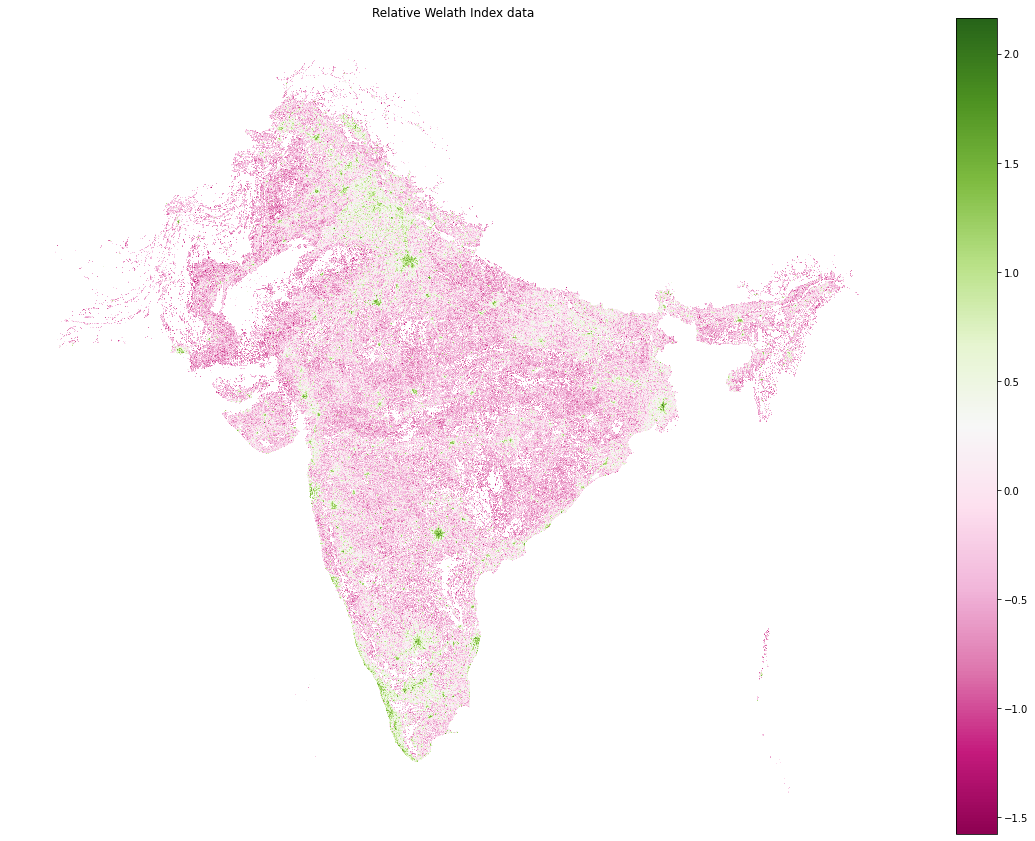

In [9]:
#plot data 

gdf_QK.plot(column='rwi',cmap='PiYG',figsize=(20,15), legend =('On'))
plt.axis('off')
plt.title('Relative Welath Index data')
plt.show()

#### Download

In [8]:
#export gdf as shapfile
# gdf_QK.to_file("FB_QK_dataIndia.shp")